In [1]:
# Import datas and set up
import numpy as np
import pandas as pd

PATH = r"D:/apm466/bonds_master_all.csv"
df0 = pd.read_csv(PATH)

df0["date"] = pd.to_datetime(df0["date"])
df0["Maturity Date"] = pd.to_datetime(df0["Maturity Date"], errors="coerce")

asof = df0["date"].min()

static = (
    df0.dropna(subset=["ISIN", "Maturity Date"])
       .drop_duplicates("ISIN")
       .copy()
)

# pick the selected bonds
md = static["Maturity Date"]
static = static[((md.dt.month == 3) & (md.dt.day == 1)) | ((md.dt.month == 9) & (md.dt.day == 1))].copy()

static["T_years"] = (static["Maturity Date"] - asof).dt.days / 365
static = static[(static["T_years"] > 0) & (static["T_years"] <= 6.0)]

targets = np.arange(0.5, 5.0 + 1e-9, 0.5)
picked, used = [], set()

for t in targets:
    cand = static[~static["ISIN"].isin(used)].copy()
    cand["gap"] = (cand["T_years"] - t).abs()

    if t == 5.0:
        cand2 = cand[cand["T_years"] >= 5.0]
        if len(cand2) > 0:
            cand = cand2

    best = cand.sort_values("gap").head(1)
    if len(best) == 0:
        print("No candidate for target:", t)
        continue

    isin = best["ISIN"].iloc[0]
    used.add(isin)
    picked.append(isin)

SELECTED_ISIN = picked
print("asof =", asof.date())
print("Selected ISIN (10):", SELECTED_ISIN)

df = df0[df0["ISIN"].isin(SELECTED_ISIN)].copy()


asof = 2026-01-05
Selected ISIN (10): ['CA135087L930', 'CA135087M847', 'CA135087N837', 'CA135087P576', 'CA135087Q491', 'CA135087Q988', 'CA135087R895', 'CA135087S471', 'CA135087T388', 'CA135087T792']


In [2]:
#Check dataframe
print(df.columns)


Index(['Term', 'bond_page_url', 'tkData', 'chart_json_url', 'ISIN', 'Name',
       'Country', 'Issuer', 'Issue Volume', 'Currency', 'Issue Price',
       'Issue Date', 'Coupon', 'Denomination', 'Quotation Type',
       'Payment Type', 'Special Coupon Type', 'Maturity Date',
       'Coupon Payment Date', 'Payment Frequency', 'No. of Payments per Year',
       'Coupon Start Date', 'Final Coupon Date', 'Floater?', 'date',
       'Close Price (% of par)'],
      dtype='object')


In [3]:
# =========================
#2)coupon_rate / clean_price
# =========================
def parse_coupon_to_rate(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().replace("%", "").replace(",", ".")
    return pd.to_numeric(s, errors="coerce") / 100.0

F = 100.0
FREQ = 2  

df["coupon_rate"] = df["Coupon"].apply(parse_coupon_to_rate)
df["clean_price"] = pd.to_numeric(df["Close Price (% of par)"], errors="coerce")

df["T"] = (df["Maturity Date"] - df["date"]).dt.days / 365

# =========================
# 3) dirty price = clean + accrued interest）
# =========================
def accrued_interest_semiannual(date, maturity, coupon_rate):
    if pd.isna(date) or pd.isna(maturity) or pd.isna(coupon_rate):
        return np.nan
    if maturity <= date:
        return 0.0
    next_cp = maturity
    while True:
        last_cp = next_cp - pd.DateOffset(months=6)
        if last_cp <= date:
            break
        next_cp = last_cp

    C = F * coupon_rate / 2.0
    frac = (date - last_cp).days / (next_cp - last_cp).days
    return C * frac

df["accrued"] = df.apply(lambda r: accrued_interest_semiannual(
    r["date"], r["Maturity Date"], r["coupon_rate"]
), axis=1)

df["dirty_price"] = df["clean_price"] + df["accrued"]

print(df[["date","Maturity Date","coupon_rate","clean_price","accrued","dirty_price"]].head())

         date Maturity Date  coupon_rate  clean_price   accrued  dirty_price
66 2026-01-05    2026-09-01         0.01       99.145  0.348066    99.493066
67 2026-01-06    2026-09-01         0.01       99.145  0.350829    99.495829
68 2026-01-07    2026-09-01         0.01       99.165  0.353591    99.518591
69 2026-01-08    2026-09-01         0.01       99.160  0.356354    99.516354
70 2026-01-09    2026-09-01         0.01       99.190  0.359116    99.549116


In [4]:
from scipy.optimize import brentq
from dateutil.relativedelta import relativedelta

F = 100
FREQ = 2  # semi-annual

def yearfrac_act365(d0, d1):
    return (d1 - d0).days / 365.0

def bond_cashflow_times(settle, next_coupon, maturity, FREQ=2):
    dates = []
    step_months = 12 // FREQ
    d = next_coupon
    
    while d <= settle:
        d = d + relativedelta(months=step_months)

    while d < maturity:
        dates.append(d)
        d = d + relativedelta(months=step_months)

    dates.append(maturity)

    times = np.array([yearfrac_act365(settle, di) for di in dates], dtype=float)
    return times

def price_from_ytm(y, coupon_rate, settle, next_coupon, maturity, F=100, FREQ=2):
    times = bond_cashflow_times(settle, next_coupon, maturity, FREQ)
    if times.size == 0:
        return np.nan

    r = y / FREQ
    if 1 + r <= 0:
        return np.nan

    disc = (1 + r) ** (-FREQ * times)

    c = F * coupon_rate / FREQ
    cashflows = np.full(times.shape, c, dtype=float)
    cashflows[-1] += F

    return float(np.sum(cashflows * disc))

def solve_ytm(price, coupon_rate, settle, next_coupon, maturity, F=100, FREQ=2):
    if not (np.isfinite(price) and np.isfinite(coupon_rate)):
        return np.nan
    if maturity <= settle:
        return np.nan

    def f(y):
        p = price_from_ytm(y, coupon_rate, settle, next_coupon, maturity, F=F, FREQ=FREQ)
        if not np.isfinite(p):
            return np.nan
        return p - price

    grid = np.array([-0.20, -0.10, -0.05, -0.02, 0.00, 0.02, 0.05, 0.10, 0.20, 0.50, 1.00, 2.00, 5.00])
    vals = np.array([f(y) for y in grid], dtype=float)

    for i in range(len(grid) - 1):
        a, b = grid[i], grid[i+1]
        fa, fb = vals[i], vals[i+1]
        if np.isfinite(fa) and np.isfinite(fb) and fa * fb <= 0:
            return float(brentq(lambda yy: f(yy), a, b, maxiter=500))

    return np.nan


In [ ]:
#calculate next coupon
def next_coupon_0301_0901(settle, maturity):
    settle = pd.to_datetime(settle)
    maturity = pd.to_datetime(maturity)

    years = [settle.year, settle.year + 1, settle.year + 2]
    cands = []
    for y in years:
        cands.append(pd.Timestamp(y, 3, 1))
        cands.append(pd.Timestamp(y, 9, 1))

    cands = [d for d in cands if d > settle and d <= maturity]
    if len(cands) == 0:
        return maturity
    return min(cands)

df["date"] = pd.to_datetime(df["date"])
df["Maturity Date"] = pd.to_datetime(df["Maturity Date"])

df["ytm"] = df.apply(
    lambda r: solve_ytm(
        price       = r["dirty_price"],
        coupon_rate = r["coupon_rate"],
        settle      = r["date"],
        next_coupon = next_coupon_0301_0901(r["date"], r["Maturity Date"]),
        maturity    = r["Maturity Date"],
        F=100, FREQ=2
    ),
    axis=1
)
S


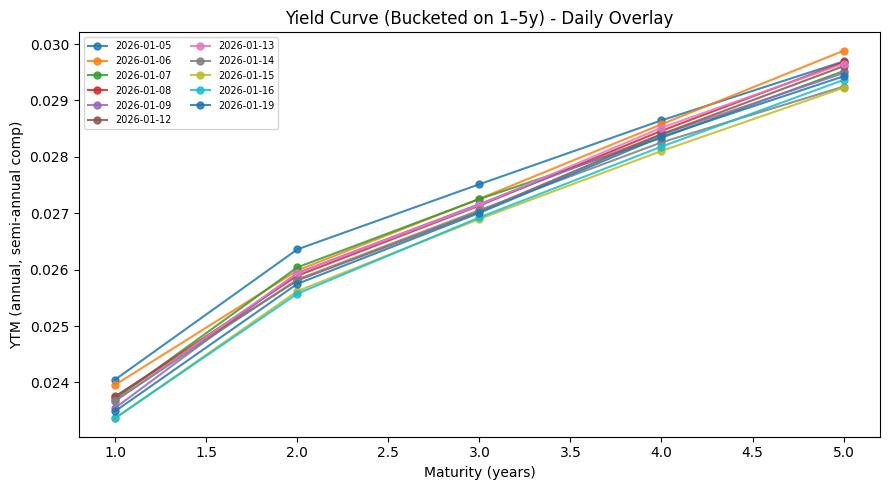

In [ ]:
#Plotting
import matplotlib.pyplot as plt

GRID = np.array([1,2,3,4,5], dtype=float)

df["T_bucket"] = np.clip(np.round(df["T"]).astype(int), 1, 5)

ytm_curves = {}
for d, g in df.groupby("date"):
    s = g.groupby("T_bucket")["ytm"].mean()
    ytm_curves[pd.to_datetime(d)] = np.array([s.get(int(x), np.nan) for x in GRID], dtype=float)


plt.figure(figsize=(9,5))
for d, yvals in ytm_curves.items():
    plt.plot(GRID, yvals, marker="o", markersize=5, alpha=0.85, label=str(d.date()))

plt.xlabel("Maturity (years)")
plt.ylabel("YTM (annual, semi-annual comp)")
plt.title("Yield Curve (Bucketed on 1–5y) - Daily Overlay")
plt.legend(fontsize=7, ncol=2)
plt.tight_layout()
plt.show()


In [ ]:
#Sample YTM dataframe
from IPython.display import display

# df should already contain: date, Maturity Date, dirty_price, ytm (and ideally T_years)
one_day = df["date"].min()

sample_cols = ["date", "Maturity Date", "dirty_price", "T", "ytm"]
sample_df = (
    df.loc[df["date"] == one_day, sample_cols]
      .sort_values("T")
      .head(10)
      .copy()
)

display(sample_df)


,date,Maturity Date,dirty_price,T,ytm
66,2026-01-05,2026-09-01,99.493066,0.654795,0.023179
99,2026-01-05,2027-03-01,99.035083,1.150685,0.024924
165,2026-01-05,2027-09-01,101.177182,1.654795,0.026074
198,2026-01-05,2028-03-01,102.948232,2.153425,0.026644
220,2026-01-05,2028-09-01,102.471215,2.657534,0.027163
396,2026-01-05,2029-03-01,105.022265,3.153425,0.027866
297,2026-01-05,2029-09-01,103.438232,3.657534,0.028505
286,2026-01-05,2030-03-01,100.450182,4.153425,0.028787
352,2026-01-05,2030-09-01,100.122182,4.657534,0.029394
308,2026-01-05,2031-03-01,99.770182,5.153425,0.029989


In [ ]:
# =========================
#  Bootstrapping discount factors
# =========================
df["T_years"] = (df["Maturity Date"] - df["date"]).dt.days / 365.0

df = df.dropna(subset=["dirty_price", "coupon_rate", "T_years"])
df = df[(df["T_years"] > 0) & (df["T_years"] <= 6.0)].copy()

TARGET_GRID = np.array([1, 2, 3, 4, 5], dtype=float)

def bootstrap_spot_for_day(day_df):
    """
    Return dict {1: S1, 2: S2, ..., 5: S5} for one day.
    Uses semi-annual cashflow grid, bootstraps DF, then converts to spot.
    """
    day_df = day_df.sort_values("T_years").copy()

    DF = {} 

    for _, row in day_df.iterrows():
        P = float(row["dirty_price"])
        c = float(row["coupon_rate"])
        T = float(row["T_years"])

        Tn = round(T * 2) / 2.0
        if Tn <= 0:
            continue

        n = int(round(Tn * 2))  
        times = [0.5 * k for k in range(1, n + 1)]
        C = (c / 2.0) * F

        pv_known = 0.0
        for t in times[:-1]:
            if t not in DF:
                pv_known = None
                break
            pv_known += C * DF[t]

        if pv_known is None:
            continue

        df_T = (P - pv_known) / (F + C)

        # sanity check
        if df_T <= 0 or df_T >= 1.5:
            continue

        DF[Tn] = df_T

    # convert DF -> spot rates 
    spots = {}
    for T in TARGET_GRID:
        if T in DF:
            dfT = DF[T]
            S = 2.0 * (dfT ** (-1.0 / (2.0 * T)) - 1.0)
            spots[T] = S
        else:
            spots[T] = np.nan

    return spots


                 1.0       2.0       3.0       4.0       5.0
2026-01-05  0.022317  0.019873  0.022673  0.026507  0.028255
2026-01-06  0.021974  0.019576  0.022405  0.026698  0.028454
2026-01-07  0.021632  0.019530  0.022334  0.026292  0.028070
2026-01-08  0.021494  0.019382  0.022197  0.026456  0.028202
2026-01-09  0.021460  0.019386  0.022195  0.026208  0.027983


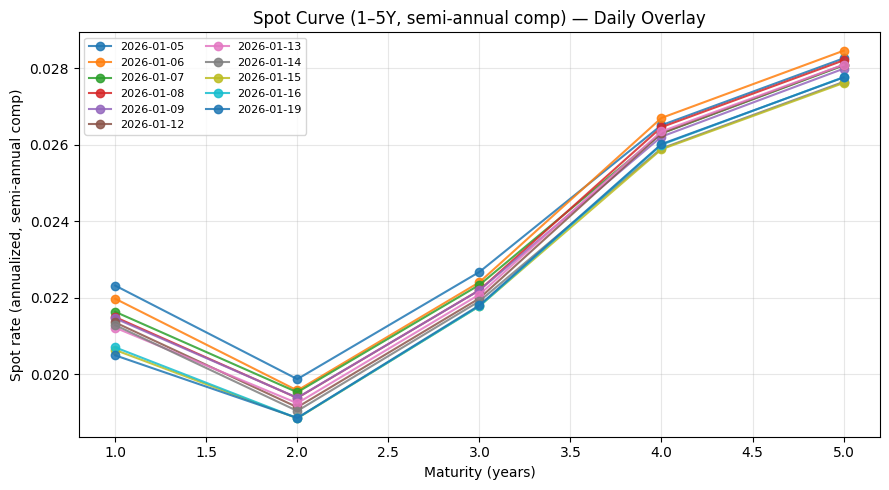

In [ ]:
# compute spot curves for each day
spot_curves = {}
for d, g in df.groupby("date"):
    spot_curves[d] = bootstrap_spot_for_day(g)

spot_df = pd.DataFrame(spot_curves).T.sort_index()  
print(spot_df.head())

# =========================
# 4) Plot: 1-5y spot curve overlay
# =========================
plt.figure(figsize=(9, 5))
for d in spot_df.index:
    y = spot_df.loc[d, TARGET_GRID].values.astype(float)
    if np.all(np.isnan(y)):
        continue
    plt.plot(TARGET_GRID, y, marker="o", linewidth=1.5, alpha=0.85, label=str(d.date()))

plt.title("Spot Curve (1–5Y, semi-annual comp) — Daily Overlay")
plt.xlabel("Maturity (years)")
plt.ylabel("Spot rate (annualized, semi-annual comp)")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
# =========================
# 5) Forward curve 
# =========================

def fwd_1y_from_spots(S1, ST, T):
    """
    Compute 1-year-start forward rate f_{1,T} for period [1, T]
    """
    if np.isnan(S1) or np.isnan(ST):
        return np.nan
    n = T - 1.0

    # (1 + S/2)^(2*T)
    A_T = (1.0 + ST / 2.0) ** (2.0 * T)
    A_1 = (1.0 + S1 / 2.0) ** (2.0 * 1.0)

    # (1 + f/2) = (A_T / A_1)^(1/(2n))  =>  f = 2*(... - 1)
    f = 2.0 * ((A_T / A_1) ** (1.0 / (2.0 * n)) - 1.0)
    return f

# build forward curves for each day
FWD_ENDS = np.array([2, 3, 4, 5], dtype=float)  # end maturities
forward_curves = {}

for d in spot_df.index:
    S1 = float(spot_df.loc[d, 1]) if 1 in spot_df.columns else np.nan
    fvals = []
    for T in FWD_ENDS:
        ST = float(spot_df.loc[d, T]) if T in spot_df.columns else np.nan
        fvals.append(fwd_1y_from_spots(S1, ST, T))
    forward_curves[d] = fvals

forward_df = pd.DataFrame(forward_curves, index=FWD_ENDS).T.sort_index()
forward_df.columns = ["1y-1y", "1y-2y", "1y-3y", "1y-4y"] 

print(forward_df.head())



               1y-1y     1y-2y     1y-3y     1y-4y
2026-01-05  0.017432  0.022851  0.027906  0.029742
2026-01-06  0.017181  0.022620  0.028275  0.030077
2026-01-07  0.017431  0.022685  0.027848  0.029682
2026-01-08  0.017272  0.022549  0.028113  0.029882
2026-01-09  0.017314  0.022563  0.027793  0.029617


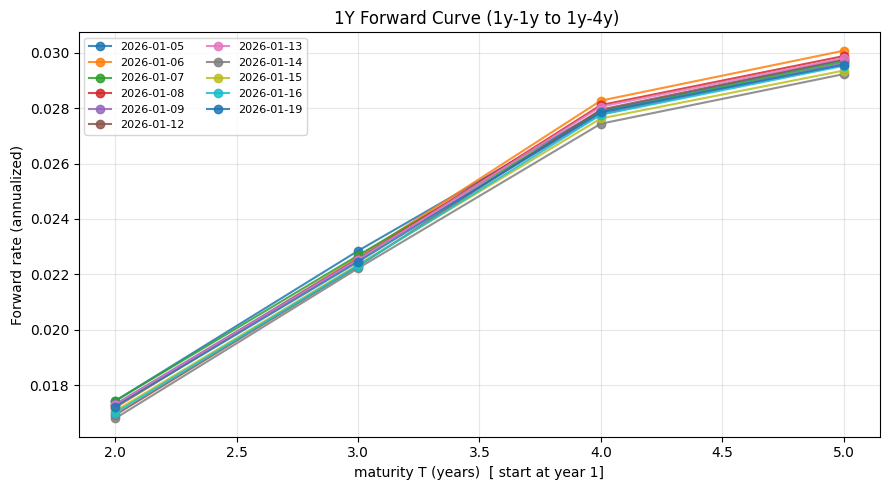

In [ ]:
# =========================
# 6) Plot: forward curve overlay (each day one line)
# =========================
plt.figure(figsize=(9, 5))
x = FWD_ENDS  # 2..5 (end maturity)
for d in forward_df.index:
    y = forward_df.loc[d].values.astype(float)
    if np.all(np.isnan(y)):
        continue
    plt.plot(x, y, marker="o", linewidth=1.5, alpha=0.85, label=str(d.date()))

plt.title("1Y Forward Curve (1y-1y to 1y-4y) ")
plt.xlabel("maturity T (years)  [ start at year 1]")
plt.ylabel("Forward rate (annualized)")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:
# =========================
#7) Covariance matrices of daily log-returns (yield & forward)
# =========================

def curves_dict_to_df(curves_dict, colnames):
    """curves_dict: {date -> array([...])}"""
    idx = sorted(pd.to_datetime(list(curves_dict.keys())))
    mat = np.vstack([np.array(curves_dict[d], dtype=float) for d in idx])
    df = pd.DataFrame(mat, index=idx, columns=colnames)
    df.index.name = "date"
    return df

def to_decimal_rates(df_rates):
    x = df_rates.copy()
    med = np.nanmedian(x.values)
    if np.isfinite(med) and med > 1.0:  
        x = x / 100.0
    return x

def log_returns(df_rates):
    x = df_rates.copy()
    x = x.where(x > 0)
    lr = np.log(x.shift(-1) / x)
    lr = lr.iloc[:-1] 
    return lr

# yields covariaance:
yield_cols = [f"y{int(t)}" for t in GRID] 
yield_df = curves_dict_to_df(ytm_curves, yield_cols)
yield_df = to_decimal_rates(yield_df)

yield_lr = log_returns(yield_df)
yield_cov = yield_lr.cov() 

print("Yield covariance matrix (log-returns):")
print(yield_cov)




Yield covariance matrix (log-returns):
          y1        y2        y3        y4        y5
y1  0.000048  0.000004  0.000002  0.000021  0.000021
y2  0.000004  0.000041  0.000027  0.000011 -0.000014
y3  0.000002  0.000027  0.000019  0.000009 -0.000006
y4  0.000021  0.000011  0.000009  0.000030  0.000031
y5  0.000021 -0.000014 -0.000006  0.000031  0.000054


In [ ]:
# forwards covariance
fwd_cols = ["fwd_1y1y", "fwd_1y2y", "fwd_1y3y", "fwd_1y4y"]

if "forward_curves" in globals() and len(forward_curves) > 0:
    fwd_df = curves_dict_to_df(forward_curves, fwd_cols)
    fwd_df = to_decimal_rates(fwd_df)

    fwd_lr = log_returns(fwd_df)
    fwd_cov = fwd_lr.cov() 

    print("\nForward covariance matrix (log-returns):")
    print(fwd_cov)

else:
    fwd_cov = None
    print("\n[Skip] forward_curves not found")



Forward covariance matrix (log-returns):
          fwd_1y1y  fwd_1y2y  fwd_1y3y  fwd_1y4y
fwd_1y1y  0.000290  0.000137  0.000019  0.000009
fwd_1y2y  0.000137  0.000067  0.000008  0.000003
fwd_1y3y  0.000019  0.000008  0.000138  0.000116
fwd_1y4y  0.000009  0.000003  0.000116  0.000099


In [ ]:
# =========================
# 8) Eigenvalues & eigenvectors 
# =========================

def eig_report(cov_df, name):
    C = cov_df.values.astype(float)

    eigvals, eigvecs = np.linalg.eigh(C)

    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    print(f"\n{name} eigenvalues (desc):")
    print(eigvals)
    
    v1 = eigvecs[:, 0]

    v1 = v1 / np.linalg.norm(v1)

    print(f"\n{name} first eigenvalue:")
    print(eigvals[0])

    print(f"\n{name} first eigenvector (loadings, aligned to columns):")
    print(pd.Series(v1, index=cov_df.columns))

    return eigvals, eigvecs

# Calculating Yield PCA
yield_eigvals, yield_eigvecs = eig_report(yield_cov, "YIELD")

if fwd_cov is not None:
    fwd_eigvals, fwd_eigvecs = eig_report(fwd_cov, "FORWARD")


YIELD eigenvalues (desc):
[9.42817869e-05 6.76533480e-05 2.84615758e-05 9.94672741e-07
 7.91942321e-07]

YIELD first eigenvalue:
9.428178685075366e-05

YIELD first eigenvector (loadings, aligned to columns):
y1   -0.538238
y2    0.026010
y3   -0.009384
y4   -0.497997
y5   -0.679364
dtype: float64

FORWARD eigenvalues (desc):
[3.59350492e-04 2.32533968e-04 1.75281891e-06 6.73647105e-07]

FORWARD first eigenvalue:
0.0003593504920458058

FORWARD first eigenvector (loadings, aligned to columns):
fwd_1y1y   -0.889290
fwd_1y2y   -0.423233
fwd_1y3y   -0.142392
fwd_1y4y   -0.098804
dtype: float64


In [11]:
#output full YTM-results for 10 bonds

full_cols = ["date", "Maturity Date", "dirty_price", "T", "ytm"]
full_df = df[full_cols].sort_values(["date", "T"]).copy()

full_df.to_csv("D:/apm466/ytm_full_results.csv", index=False)
print("Saved: ytm_full_results.csv")


Saved: ytm_full_results.csv
